# Assignment 7: Dimensionality Reduction

## Follow These Steps Before Submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking **'Runtime' > 'Restart session and run all'**.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.

# Dataset

In this assignment, you will work on a text dataset. The Yelp reviews dataset consists of reviews from Yelp. It is extracted from the Yelp Dataset Challenge 2015 data. For more information, please refer to http://www.yelp.com/dataset_challenge. The Yelp reviews polarity dataset is a subset of Yelp reviews dataset and is constructed by considering stars 1 and 2 negative, and 3 and 4 positive.

In [ ]:
# imports
import os
import numpy as np
import pandas as pd
import polars as pl
from scipy.sparse import csr_matrix
import sklearn.feature_extraction.text as sktext
from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD
import re
from sklearn.manifold import TSNE

import umap

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
!gdown https://drive.google.com/uc?id=1A0-Q7SbdoA3r7aawraRSwMgKujBYlFLv

Downloading...
From: https://drive.google.com/uc?id=1A0-Q7SbdoA3r7aawraRSwMgKujBYlFLv
To: /content/yelp.csv
100% 1.09M/1.09M [00:00<00:00, 13.0MB/s]


# Part 1: Data Preprocessing

## Question 1.1: Load data

Read the **`yelp.csv`** file as a **`polars.DataFrame`** and show the first 5 rows of the dataframe and its descriptive statistics.

In [ ]:
# YOUR CODE HERE
texts = pl.read_csv('yelp.csv')
texts.head()

Sentiment,Review
i64,str
0,"""Maintenance here is ridiculous…"
1,"""I really enjoy smaller more in…"
1,"""Looking at their menu, I was a…"
1,"""Best sandwiches in Las Vegas! …"
0,"""Was upset because they didnt h…"


In [ ]:
texts.describe()

statistic,Sentiment,Review
str,f64,str
"""count""",1500.0,"""1500"""
"""null_count""",0.0,"""0"""
"""mean""",0.494,null
"""std""",0.500131,null
"""min""",0.0,"""$24 for a burger and beer. \n…"
"""25%""",0.0,null
"""50%""",0.0,null
"""75%""",1.0,null
"""max""",1.0,"""wow, where do I begin? It too…"


## Question 1.2: Convert categorical variable

Since we are not predicting the categorical variable in this assignment, let's convert **`Sentiment`** to string:
- Replace **1** with **`positive`**.
- Replace **0** with **`negative`**.

Display the first 5 rows of the resulting dataframe.


In [ ]:
# YOUR CODE HERE
texts = texts.with_columns(pl.col('Sentiment').cast(pl.Utf8).replace({1: 'positive', 0: 'negative'}))
texts.head()

Sentiment,Review
str,str
"""negative""","""Maintenance here is ridiculous…"
"""positive""","""I really enjoy smaller more in…"
"""positive""","""Looking at their menu, I was a…"
"""positive""","""Best sandwiches in Las Vegas! …"
"""negative""","""Was upset because they didnt h…"


## Question 1.3: Transform text

Apply **`Term Frequency - Inverse Document Frequency`** transformation using [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html):
- Eliminate accents and other characters
- Eliminate stopwords
- Eliminate words that appear in less than 5% and words that appear in more than 95% of texts
- Apply sublinear tf scaling

Extract and save the word list. Report the number of words that are kept.

In [ ]:
# YOUR CODE HERE
TfIDFTransformer = sktext.TfidfVectorizer(strip_accents='unicode', # Eliminate accents and special characters
                      stop_words='english', # Eliminates stop words.
                      min_df = 0.05, # Eliminate words that do not appear in more than 5% of texts
                      max_df = 0.95, # Eliminate words that appear in more than 95% of texts
                      sublinear_tf=True # Use sublinear weights (softplus)
                      )
TfIDF_yelp = TfIDFTransformer.fit_transform(texts['Review'])

word_list = TfIDFTransformer.get_feature_names_out()
len(word_list)

157

## Question 1.4: Explore words

Based on TF-IDF scores, show the 10 most <font color='red'>important</font> words and the 10 least <font color='red'>important</font> words.

Hint: You might need to use [`np.argsort`](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html). Pay attention to sorting order.

In [ ]:
# YOUR CODE HERE
tfidf_scores = TfIDF_yelp.sum(axis=0).A1 # Summing up TF-IDF scores for each word
top_indices = np.argsort(tfidf_scores)[-10:][::-1] # Get the indices of the top 10 words based on TF-IDF scores
top_words = word_list[top_indices]
top_words

array(['food', 'place', 'good', 'great', 'service', 'like', 'just',
       'time', 'really', 'don'], dtype=object)

In [ ]:
bottom_indices = np.argsort(tfidf_scores)[:10]
bottom_words = word_list[bottom_indices]
bottom_words

array(['having', 'tell', 'half', 'decided', 'town', '30', 'finally',
       'kind', 'review', 'reviews'], dtype=object)

# Part 2: Dimensionality Reduction

## Question 2.1: PCA

(1) Apply **normal PCA**. Set the number of components to 100. Report the percentage variance explained by the 100 PCs.

(2) Show the words that have positive weight in the **third PC** (index 2).

In [ ]:
# (1) YOUR CODE HERE
# Do normal PCA on the data set
nPCA = PCA(n_components=100)

# Now we fit. We need to transform our matrix to dense format first.
nPCA.fit(np.asarray(TfIDF_yelp.todense()))

# Let's calculate the variance of the two components.
total_variance = np.sum(nPCA.explained_variance_ratio_) * 100
print(f'The total explained variance of the first 100 components from PCA is {total_variance:.3f} %')

The total explained variance of the first 100 components from PCA is 80.074 %


In [ ]:
# (2) YOUR CODE HERE
word_list[nPCA.components_[2,:]>0]

array(['10', '20', '30', 'ask', 'asked', 'away', 'bad', 'business',
       'called', 'came', 'check', 'come', 'customer', 'decided', 'did',
       'didn', 'drinks', 'finally', 'food', 'friends', 'gave', 'got',
       'great', 'half', 'happy', 'hour', 'later', 'left', 'let',
       'location', 'long', 'manager', 'minutes', 'money', 'ok', 'open',
       'order', 'ordered', 'pay', 'price', 'recommend', 'restaurant',
       'review', 'said', 'server', 'service', 'staff', 'star', 'table',
       'tell', 'time', 'times', 'told', 'took', 'wait', 'wanted', 'wasn',
       'went', 'work'], dtype=object)

## Question 2.2: LSA

(1) Apply **LSA** using [`TruncatedSVD`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html). Set:
- number of components to 100
- number of iterations to 10
- random state to 2025.

Report the percentage variance explained by the 100 PCs.

(2) Show the five words that relate the most <font color='red'>positively</font> with the **fifth PC** (index 4). What would you name this principal component?

In [ ]:
# (1) YOUR CODE HERE
svd = TruncatedSVD(n_components=100, # How many concepts to extract
                  n_iter=10, # How many iterations to run
                  random_state=2025 # Random state. As SVD is rotation-invariant, we need to set this
                  )
svd.fit(TfIDF_yelp)
print(f'The total explained variance of the first 100 components from LSA is {svd.explained_variance_ratio_.sum()*100:.3f} %')

The total explained variance of the first 100 components from LSA is 80.441 %


In [ ]:
# (2) YOUR CODE HERE
indices = np.argpartition(svd.components_[4, :], -5)[-5:]
# indices = np.argsort(svd.components_[4, :])[-5:]

[word_list[j] for j in indices]

['room', 'hotel', 'nice', 'service', 'good']

Written answer: The principal component seems to relate to good hotels reviews.

## Question 2.3: PCA vs LSA

Compare PCA and LSA. Comment on your findings.

**Written answer:**

LSA explains more variance than PCA because LSA captures the underlying semantic structure of text data. PCA works well for dense numeric data but struggles with sparse high-dimensional data.

## Question 2.4: t-SNE

Apply **t-SNE**. Set:
- number of components to 2
- random first inintialization
- try a perplexity of 2 and 10.
- tightness of natural clusters to 30
- auto learning rate
- maximum number of iterations to 1000
- maximum number of iterations without progress before we abort to 100
- use cosine metric
- gradient threshold to 0.0000001
- random state to 2025

Create a plot, showing 2D projection of our data using t-SNE for both perplexities, in separate plots. Remember to add labels and title.

Written answer: Compare the two projections. Which projection would you think separates the classes better? Why?

[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.002s...
[t-SNE] Computed neighbors for 1500 samples in 0.100s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 292.476929
[t-SNE] KL divergence after 1000 iterations: 1.564704


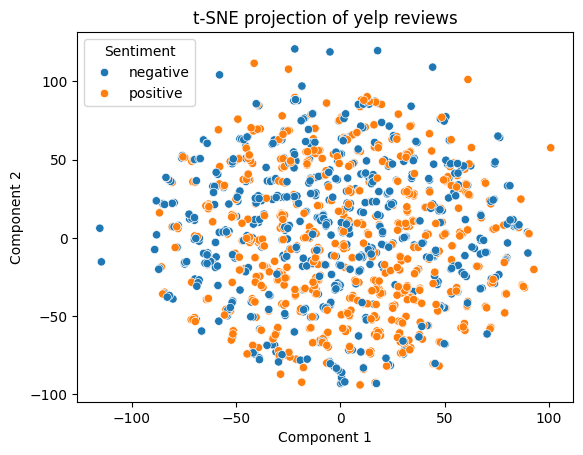

In [ ]:
#  YOUR CODE HERE - Perplexity 2
tSNEmapper = TSNE(n_components=2,               # How many dimensions to use. Never more than 2 or 3
                  init='random',                # First initialization. Sparse matrices need 'random'.  Otherwise use 'pca'
                  perplexity=2,                # Read below
                  early_exaggeration=30,        # How tight are the initial clusters.
                  learning_rate='auto',         # Related to above. Leave to auto
                  max_iter=1000,                # Very important to let iterate enough
                  n_iter_without_progress=100,  # Set early stopping
                  metric='cosine',              # Metric to use to calculate distances.
                  min_grad_norm=1e-7,           # Minimum gradient to continue iterating
                  verbose=1,                    # Verbosity
                  random_state=2025,            # Random seed
                  n_jobs=-1,                    # Parallel processes
                 )
TSNE_embedding = tSNEmapper.fit_transform(TfIDF_yelp)

sns.scatterplot(x=TSNE_embedding[:, 0], y=TSNE_embedding[:, 1], hue=texts['Sentiment'])
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("t-SNE projection of yelp reviews")
plt.show()

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.001s...
[t-SNE] Computed neighbors for 1500 samples in 0.082s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 0.178814
[t-SNE] KL divergence after 250 iterations with early exaggeration: 246.636002
[t-SNE] KL divergence after 1000 iterations: 2.547597


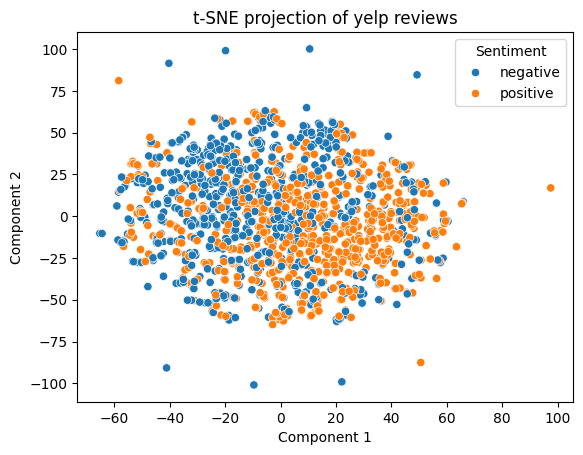

In [ ]:
#  YOUR CODE HERE - Perplexity 10
tSNEmapper = TSNE(n_components=2,               # How many dimensions to use. Never more than 2 or 3
                  init='random',                # First initialization. Sparse matrices need 'random'.  Otherwise use 'pca'
                  perplexity=10,                # Read below
                  early_exaggeration=30,        # How tight are the initial clusters.
                  learning_rate='auto',         # Related to above. Leave to auto
                  max_iter=1000,                # Very important to let iterate enough
                  n_iter_without_progress=100,  # Set early stopping
                  metric='cosine',              # Metric to use to calculate distances.
                  min_grad_norm=1e-7,           # Minimum gradient to continue iterating
                  verbose=1,                    # Verbosity
                  random_state=2025,            # Random seed
                  n_jobs=-1,                    # Parallel processes
                 )
TSNE_embedding = tSNEmapper.fit_transform(TfIDF_yelp)

sns.scatterplot(x=TSNE_embedding[:, 0], y=TSNE_embedding[:, 1], hue=texts['Sentiment'])
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("t-SNE projection of yelp reviews")
plt.show()

**Written answer: The low perplexity spreads points in the space much more, but the difference between classes is lost. On the other hand, the P10 T-SNE, while it keeps points much closer together, can show the different classes much more precisely than P2.**

## Question 2.5: UMAP

(1) Apply **UMAP**. Set:
- number of components to 2
- use 10 nearest neighbors
- use cosine metric
- number of training epochs to 1000
- effective minimum distance between embedded points to 0.1
- effective scale of embedded points to 1
- avoids excessive memory use
- do not use a random seed to allow parallel processing.

(2) Create a plot, showing 2D projection of our data using UMAP. Remember to add labels and title.

In [ ]:
# (1) YOUR CODE HERE
reducer = umap.UMAP(n_neighbors=10,              # Number of neareast neighbours to use.
                    n_components=2,              # Number of components. UMAP is robust to larger values
                    metric='cosine',             # Metric to use.
                    n_epochs=1000,               # Iterations. Set to convergence. None implies either 200 or 500.
                    min_dist=0.1,                # Minimum distance embedded points. Smaller makes clumps, larger, sparseness.
                    spread=1.0,                  # Scale to combine with min_dist
                    low_memory=False,            # Run slower, but with less memory.
                    n_jobs=-1,                   # Cores to use
                    verbose=True,                # Verbosity
                   )

# Now we train and calculate the embedding!
UMAP_embedding = reducer.fit_transform(TfIDF_yelp)

/home/cristian/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/cristian/miniconda3/envs/ml/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(angular_rp_forest=True, low_memory=False, metric='cosine', n_epochs=1000, n_jobs=1, n_neighbors=10, random_state=2025, verbose=True)
Fri Mar 14 15:09:14 2025 Construct fuzzy simplicial set
Fri Mar 14 15:09:14 2025 Finding Nearest Neighbors
Fri Mar 14 15:09:16 2025 Finished Nearest Neighbor Search
Fri Mar 14 15:09:18 2025 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Fri Mar 14 15:09:22 2025 Finished embedding


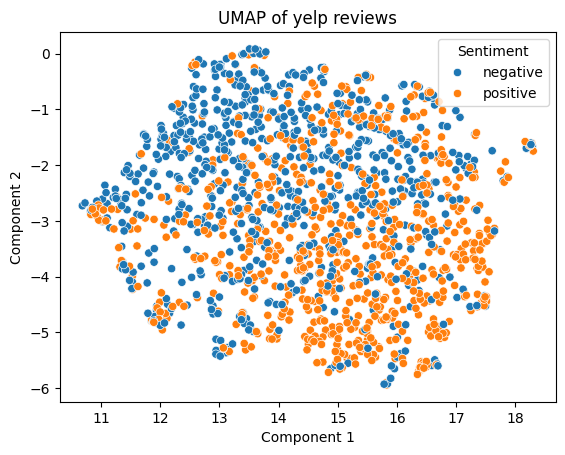

In [ ]:
# (2) YOUR CODE HERE
sns.scatterplot(x=UMAP_embedding[:, 0], y=UMAP_embedding[:, 1], hue=texts['Sentiment'])
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("UMAP of yelp reviews")
plt.show()

## Question 2.6: t-SNE vs UMAP

Compare t-SNE (perplexity 10) and UMAP. Comment on your findings.

**Written answer:**

- UMAP creates much sparser divisions, and now we can see that the blue class (negative) is in the upper left, and the orange class (positive) in the lower right.
- In the t-SNE visualization, the blue class (negative) lies on the right, while the orange class (positive) is on the left.
- Both t-SNE and UMAP struggle with overlapping points because high-dimensional text embeddings often contain smooth transitions between sentiments rather than hard separations.
- Worth trying 3 components that can be displayed in 3D visualization.